In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Flatten
import keras
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam

In [2]:
skin_df = pd.read_csv('/Users/neda/Desktop/data/HAM10000_metadata.csv')

In [3]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
skin_df['label'] = le.transform(skin_df["dx"]) 


/var/folders/g_/w9qskps96k97sjd8_rw0kbfw0000gn/T/ipykernel_1094/3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


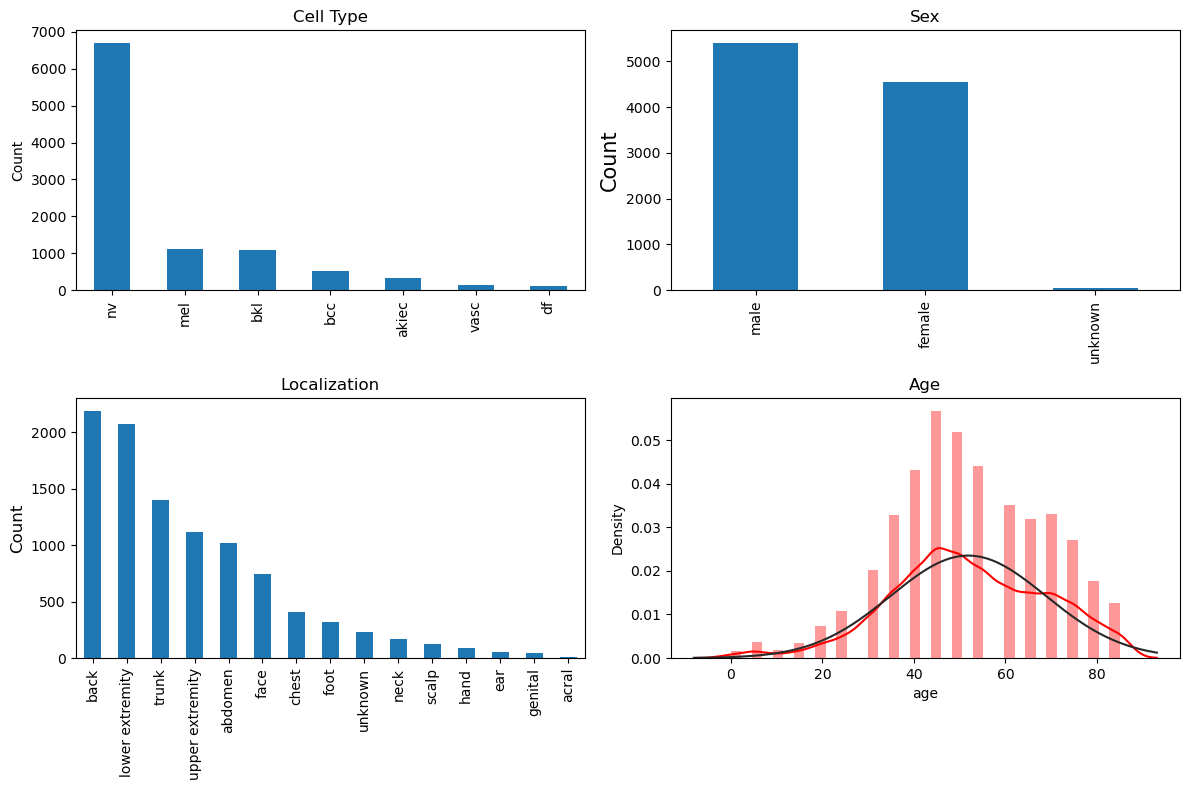

In [5]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

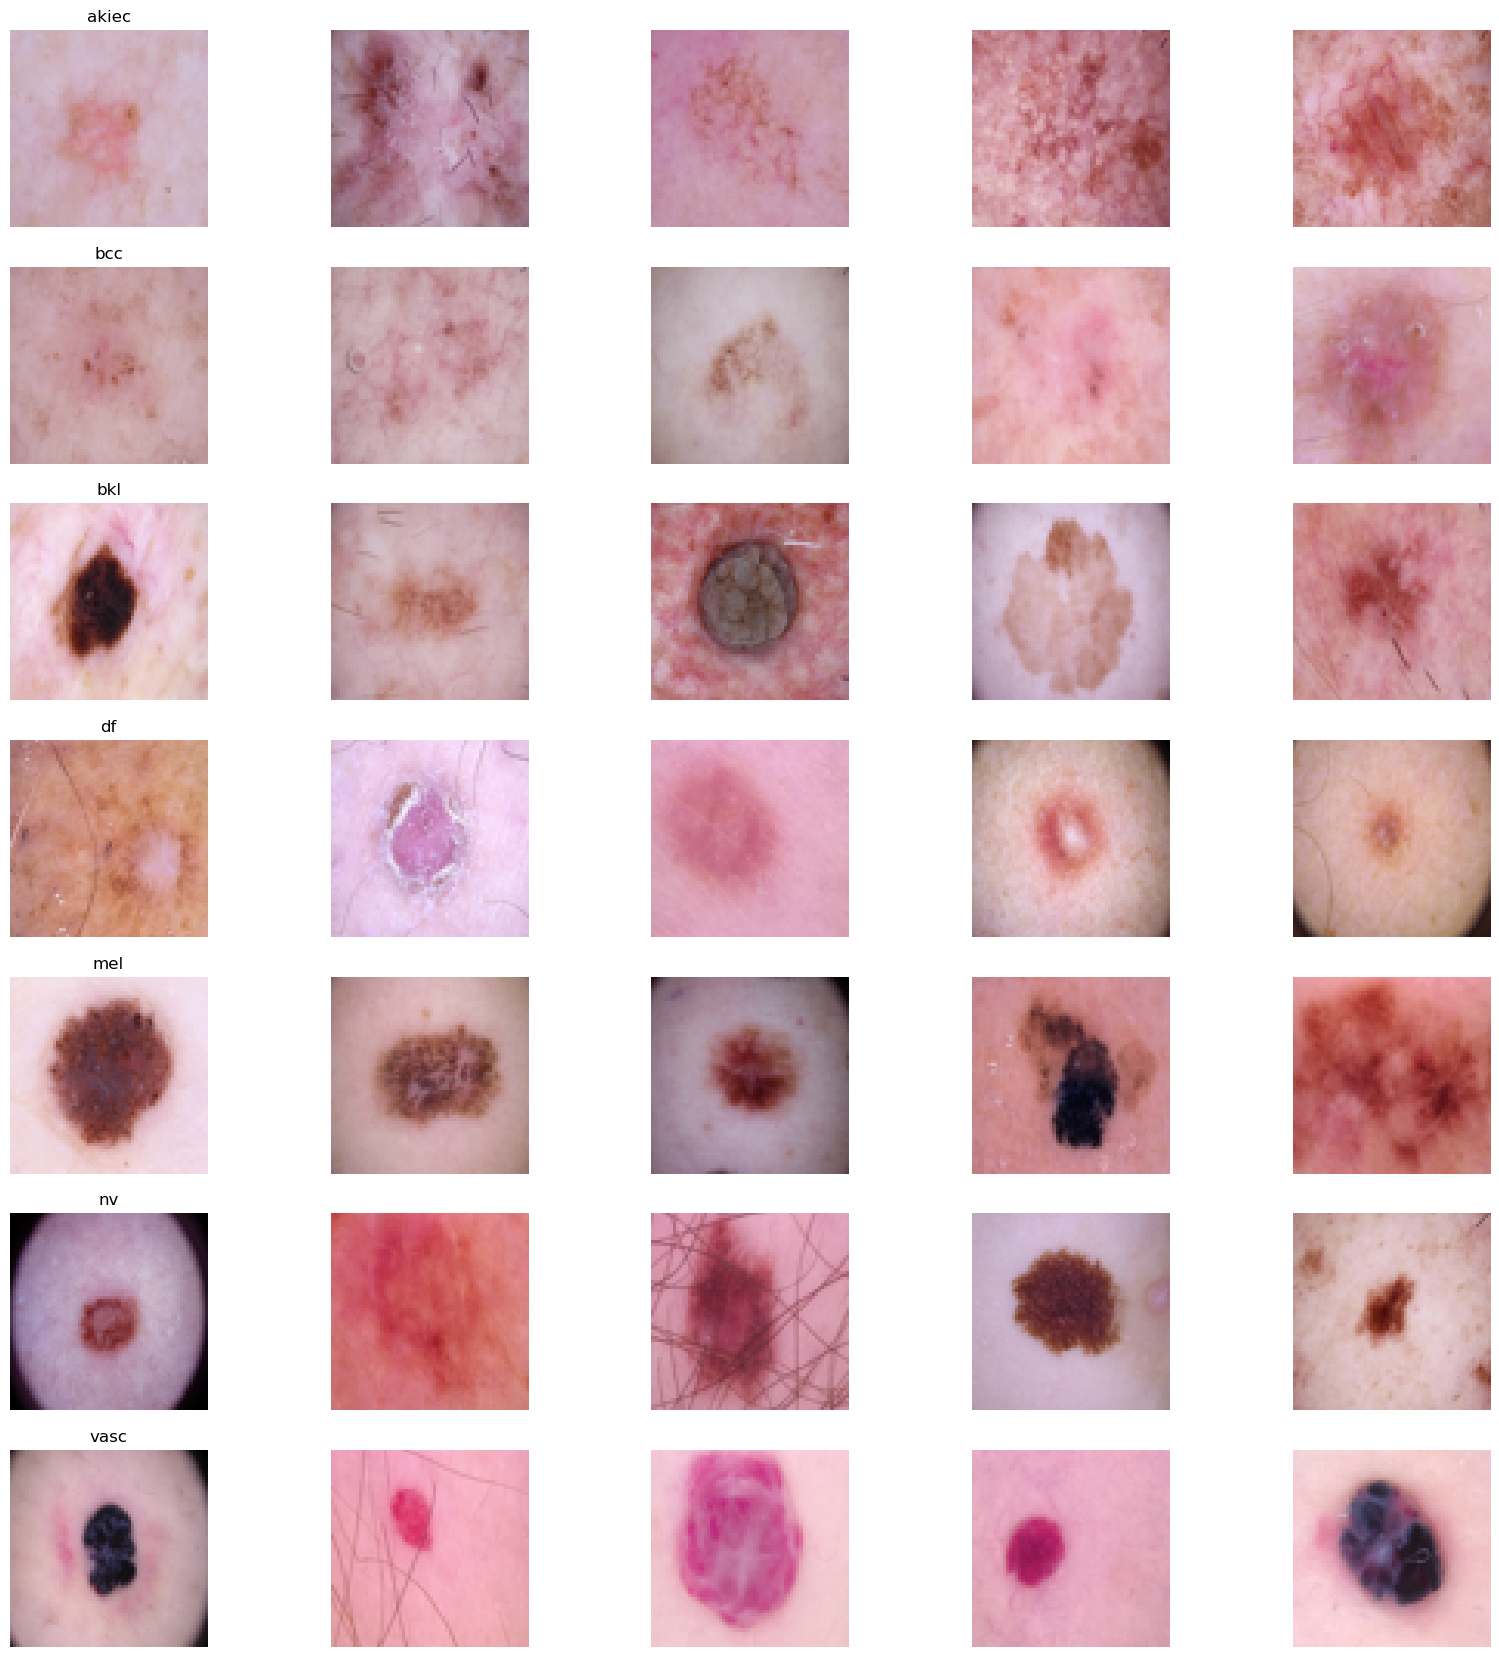

In [6]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('/Users/neda/Desktop/data/', '*', '*.jpg'))}
skin_df['path'] = skin_df['image_id'].map(image_path.get)
# Use the path to read images
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((64, 64))))

# Plotting
n_samples = 5  # number of samples for plotting
fig, axs = plt.subplots(7, n_samples, figsize=(4 * n_samples, 3 * 7))
for ax, (label, group) in zip(axs, skin_df.sort_values(['dx']).groupby('dx')):
    ax[0].set_title(label)
    for c_ax, (_, c_row) in zip(ax, group.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')


In [7]:
# Split the data into train and test sets
train_df, test_df = train_test_split(skin_df, test_size=0.2, stratify=skin_df['dx'], random_state=42)


In [8]:
# Define image size and batch size
IMG_SIZE = 64
BATCH_SIZE = 16
optimizer = Adam(learning_rate=0.0001)

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,  
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,  
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='path', 
                                                    y_col='dx', 
                                                    target_size=(IMG_SIZE,IMG_SIZE), 
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_dataframe(test_df, 
                                                x_col='path', 
                                                y_col='dx', 
                                                target_size=(IMG_SIZE,IMG_SIZE), 
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=False)
   

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [10]:
# Load pre-trained model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


2023-05-03 13:37:18.708228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:


from tensorflow.keras.applications import vgg16

vgg16_model = vgg16.VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

# Freeze pre-trained layers except last few
for layer in vgg16_model.layers[:-5]:
    layer.trainable = False

# Add classification layers
x = vgg16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
# Define fine-tuned model
model = Model(inputs=vgg16_model.input, outputs=predictions)

# Freeze pre-trained layers except last few
for layer in model.layers[:-6]:
    layer.trainable = False

# Compile the model
vgg16_model = Model(inputs=vgg16_model.input, outputs=predictions)
vgg16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping callback
earlystop_callback = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Define model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('best_model_vgg.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [14]:
# Train VGG16 model
vgg_history = vgg16_model.fit(train_generator, 
                            epochs=35, 
                            validation_data=val_generator,callbacks=[earlystop_callback, checkpoint_callback],
 
                            verbose=1)

Epoch 1/35
501/501 [==============================] - ETA: 0s - loss: 0.9559 - accuracy: 0.6810
Epoch 1: val_accuracy improved from -inf to 0.71243, saving model to best_model_vgg.h5
501/501 [==============================] - 197s 393ms/step - loss: 0.9559 - accuracy: 0.6810 - val_loss: 0.8110 - val_accuracy: 0.7124
Epoch 2/35
501/501 [==============================] - ETA: 0s - loss: 0.8432 - accuracy: 0.7043
Epoch 2: val_accuracy improved from 0.71243 to 0.72691, saving model to best_model_vgg.h5
501/501 [==============================] - 193s 384ms/step - loss: 0.8432 - accuracy: 0.7043 - val_loss: 0.7953 - val_accuracy: 0.7269
Epoch 3/35
501/501 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.7151
Epoch 3: val_accuracy improved from 0.72691 to 0.73839, saving model to best_model_vgg.h5
501/501 [==============================] - 192s 384ms/step - loss: 0.7969 - accuracy: 0.7151 - val_loss: 0.7594 - val_accuracy: 0.7384
Epoch 4/35
501/501 [====================

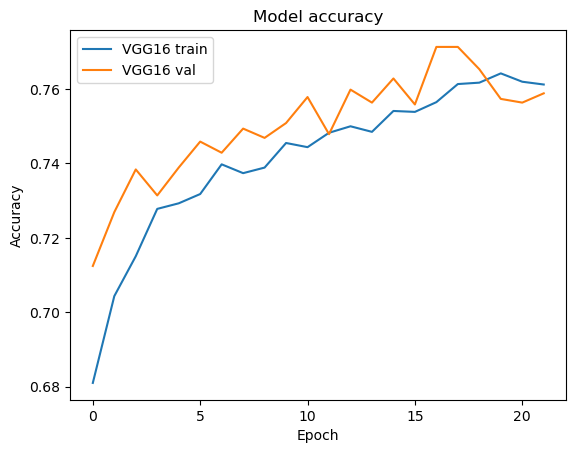

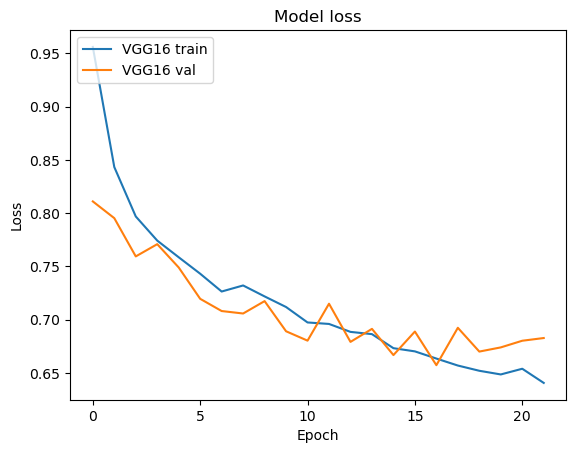

In [15]:

# Visualize comparison of accuracy and loss function
import matplotlib.pyplot as plt

# Plot training and validation accuracy for VGG16 
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG16 train', 'VGG16 val'], loc='upper left')
plt.show()

# Plot training and validation loss for VGG16 
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['VGG16 train', 'VGG16 val'], loc='upper left')
plt.show()


In [16]:

# Predict on test data using VGG16 model
vgg_pred = vgg16_model.predict(val_generator)
vgg_pred_classes = np.argmax(vgg_pred, axis=1)

126/126 [==============================] - 37s 293ms/step


In [17]:
# Get true labels for test data
true_labels = val_generator.classes

In [18]:
# Calculate accuracy for VGG16 model
vgg_acc = np.sum(vgg_pred_classes == true_labels) / len(true_labels)


print('VGG16 Test Accuracy:', vgg_acc)


VGG16 Test Accuracy: 0.7713429855217174


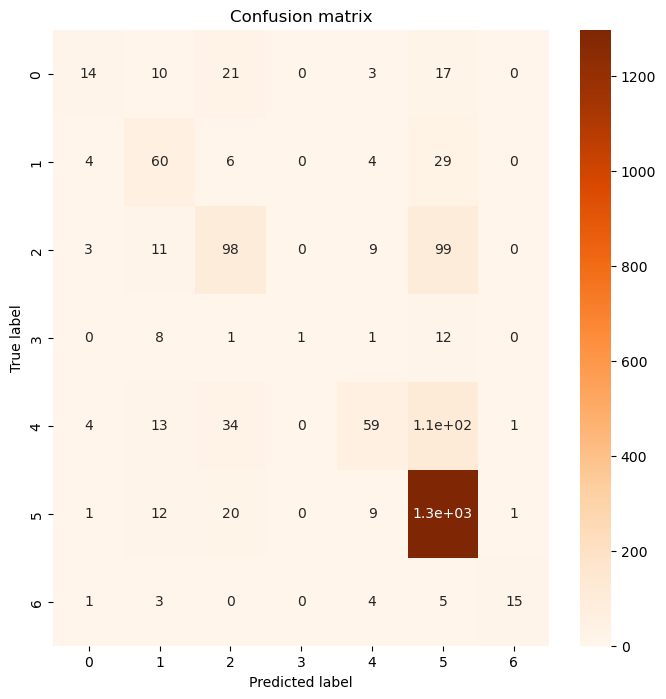

In [19]:

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_labels, vgg_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Oranges')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [20]:
model.save('/Users/neda/Desktop/my_model_diagrams/best_cancer_model.h5')

